# INF8775 – Analyse et conception d’algorithmes
# TP1 – Hiver 2021

Thiboutot, Thomas, 2143877

Barri, Alfa Umar, 1952357

Note finale :

 <u>**Date limite de remise :**</u>  21 Février 23h59 (Groupe B1), 13 février 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaisons). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème de la ligne d’horizon (The Skyline Problem) qui consiste à dessiner la silhouette de bâtiments lorsqu’ils sont vus de loin. Ces bâtiments sont juxtaposés l’un à l’autre et il est possible que l’un en cache un autre.

Chaque bâtiment est défini par le triplet `(l, r, h)` avec `h` la hauteur du bâtiment et `l` et `r` les abscisses des murs gauche et droit, respectivement.

La solution représente une suite de couples `(x, h)` représentant les coordonnées des points définissant la silhouette des bâtiments.

Soit l’exemple suivant avec 5 bâtiments :

- L'exemplaire est : `(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10),
(19, 24, 8)`
- La solution est : `(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)`

La figure B représente la silhouette (et donc la solution) tracée par les bâtiments colorés de la figure A.

In [1]:
# Problem data
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]

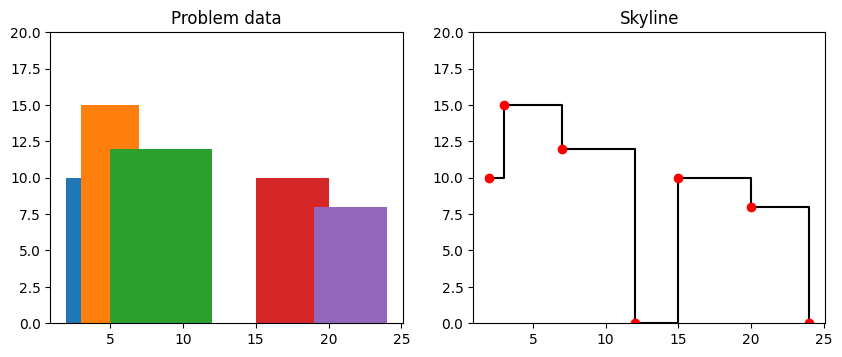

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots with equal width
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]})

# Create the first subplot to show the problem data as colored filled rectangles
for building in example_buildings:
 left, right, height = building
 axs[0].fill([left, right, right, left], [0, 0, height, height])

axs[0].set_ylim([0, 20])
axs[0].set_aspect('equal')
axs[0].set_title('Problem data')

# Create the second subplot to plot the skyline as a staircase function
x = [x for x, _ in example_skyline]
y = [y for _, y in example_skyline]
axs[1].step(x, y, where='post', color='black')

# Add the solution points as red dots
axs[1].plot(x, y, 'ro')

axs[1].set_ylim([0, 20])
axs[1].set_aspect('equal')
axs[1].set_title('Skyline')

plt.show()


## Algorithmes à implanter

On vous demande de résoudre ce problème de 3 façons différentes :

1. En utilisant un algorithme force brute simple ;
2. En utilisant un algorithme diviser pour régner ;
3. En utilisant un algorithme diviser pour régner avec seuil de récursivité non élémentaire.

Pour l’algorithme 3, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est en deçà de ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.

Vos algorithmes doivent donner des réponses où les couples `(x, h)` sont triés de façon non décroissante selon x (cf. exemple plus haut). Par ailleurs, ils ne doivent pas donner de solutions avec couples redondants, i.e. deux couples qui se suivent ne peuvent pas avoir la même hauteur ni la même abscisse. 


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [3]:
import random

max_width = 50
max_dist = 30
max_height = 300

def generate_sample(size):
    sample = []
    last_l = 0
    for _ in range(size):
        l = random.randint(last_l, last_l + max_dist)
        r = random.randint(l+1, l + max_width)
        h = random.randint(1, max_height)
        sample.append((l, r, h))
        last_l = l
    return sample

def get_dataset(seed, sizes):
    random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [4]:
import time
from scipy.stats import linregress

def verification_plot(buildings, skyline):
    # Create a figure and a set of subplots with equal width
    fig, ax = plt.subplots(figsize=(10,5))

    # Create the first subplot to show the problem data as colored filled rectangles
    for building in buildings:
        left, right, height = building
        ax.fill([left, right, right, left], [0, 0, height, height])

    # Create the second subplot to plot the skyline as a staircase function
    x = [x for x, _ in skyline]
    y = [y for _, y in skyline]
    ax.step(x, y, where='post', color='black')

    # Add the solution points as red dots
    ax.plot(x, y, 'ro')

    plt.show()


def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        solution, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()
    

def display_mesures_seuil(vals):
    x = list(vals.keys())
    y = list(vals.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps')
    plt.title('Selection du seuil')
    plt.show()

## Partie 1 : Algorithme naïf (brute force) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez un algorithme naïf pour le problème de la ligne d'horizon.

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

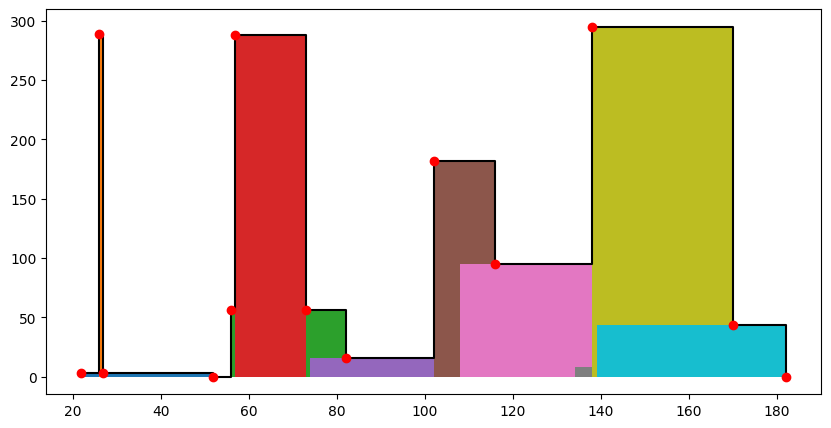

In [5]:
def skyline_bruteforce(buildings):
    assert len(buildings) > 1, "There are no buildings"
    # TODO : Implantez un algorithme naïf
    buildings = sorted(buildings)
    skyline = []
    points = []
    for i in buildings :
        points.append(((i[0], i[2])))
        points.append(((i[1], i[2]))) 
    points = sorted(points)
    prev_hauteur = 0
    for p in points:
        hauteur = 0
        for b in buildings: 
            if b[0] <= p[0] and p[0]<= b[1] and p[1] != prev_hauteur:
                hauteur = max(hauteur, b[2])
            elif b[0] <= p[0] and p[0]<= b[1] and p[1] == prev_hauteur:
                hauteur = max(hauteur, b[2]) if b[2] != prev_hauteur else max(hauteur, 0)
        if hauteur != prev_hauteur:
            prev_hauteur = hauteur
            skyline.append((p[0], hauteur)) 
    return skyline


verification_plot([(22, 52, 3), (26, 27, 289), (56, 82, 56), (57, 73, 288), (74, 106, 16), (102, 116, 182), (108, 153, 95), (134, 161, 8), (138, 170, 295), (139, 182, 44)], skyline_bruteforce([(22, 52, 3), (26, 27, 289), (56, 82, 56), (57, 73, 288), (74, 106, 16), (102, 116, 182), (108, 153, 95), (134, 161, 8), (138, 170, 295), (139, 182, 44)]))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?
n <- Nombre de bâtiment
La complexité asymptotique de l'algorithme naif est O(n^2). La fonction «sorted» de python à une complexité de O(n log(n)). L'initialisation de la skyline est O(1). La boucle d'initialisation de la liste de points se fait en O(n). Le tri des points avec «sorted» se fait également en O(n log(n)). La boucle imbriquée s'exécute en O(n * 2n) car la longueur des la liste de points est deux fois celle de la liste de bâtiment. O(2n^2) est d'ordre O(n^2). On considère la somme des évènements et on conclu que le maximum de ces fonctions est O(n^2)

### Mesures

In [6]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2143877, [150,200,250,500,1000,1500,1750,2000,2250,2500,2750,3000,3250,3500])

In [7]:
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)

Représentez vos mesures sous forme d'un tableau avec la fonction `display_measures_table`.

In [8]:
display_measures_table(measures_bruteforce)

Taille       Temps moyen (s)
150          0.0069183349609375
200          0.007053232192993164
250          0.016057252883911133
500          0.046965503692626955
1000         0.18907432556152343
1500         0.3834682941436768
1750         0.5113091468811035
2000         0.6480648517608643
2250         0.8161920070648193
2500         0.9881138324737548
2750         1.193571186065674
3000         1.3407866954803467
3250         1.615584421157837
3500         1.8843451976776122


### Analyse hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

Pour cela complétez d'abord le code de la fonction `values_test_puissance` pour obtenir les valeurs à placer sur le graphe. Utilisez ensuite la fonction `display_test_puissance` pour afficher le graphe.

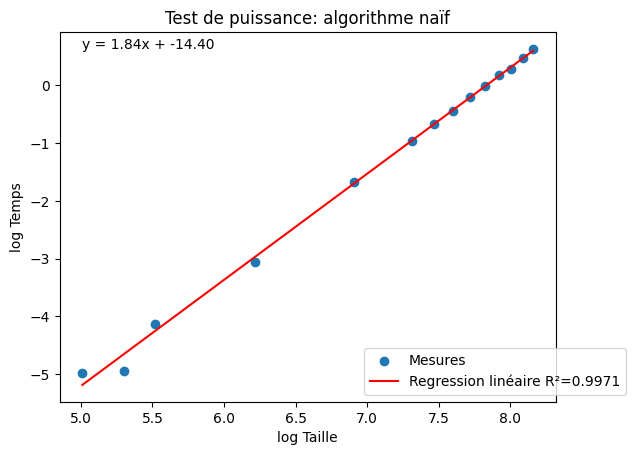

In [9]:
import math

def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs x:y pour le test de puissance
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }

display_test_puissance(values_test_puissance(measures_bruteforce), "Test de puissance: algorithme naïf")


<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.
On observe que le graphique en échelle log-log du temps en fonction de la taille donne une droite, ce qui nous indique que l'algorithme suit un temps d'ordre polynomial.
La pente de la droite est de 1.84 et l'ordonnée à l'origine est -14.40. Nous faisons donc une hypothèse sur la fonction sous-jacente h(x) qui donne l'ordre de la complexité asymptotique temporelle de notre algorithme.
Hypothèse : m = 2 => h(x) = x^2 
Cette hypothèse concorde avec notre calcul de la complexité asymptotique.

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_rapport` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_rapport` pour afficher le graphe.

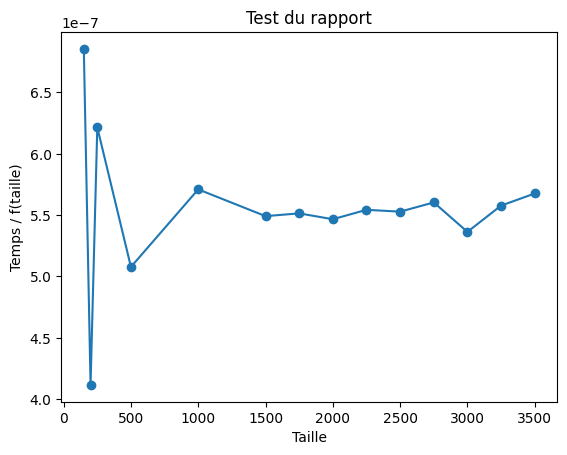

In [12]:
def values_test_rapport(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        size : measure/f(size)
        for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return x**1.84

display_test_rapport(values_test_rapport(measures_bruteforce, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport. Précisez le critère de choix de votre ou vos fonctions.

Le graphique qui représente le temps divisé par l'ordre de complexité en fonction de la taille de l'exemplaire semble donner un ensemble de points qui converge vers 5.5e-7.
On peut poser une hypothèse sur la constante multiplicative de l'algorithme naif.

Hypothèse : a = 5.5e-7

Cette valeur est comparable à l'ordonnée à l'origine du test de puissance dont la courbe est donné par: y = log(a) + m*log(x) => a = e^-14.40 = 5.57e-7

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_constantes` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_constantes` pour afficher le graphe.

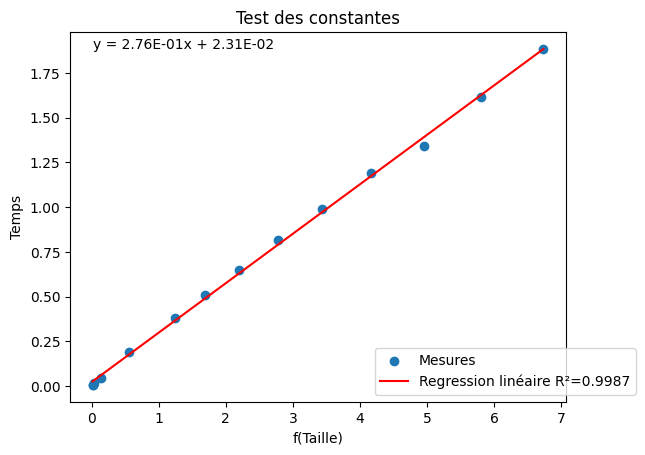

In [13]:
def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        f(size) : measure
        for size, measure in measures.items()
    }

# TODO: définissez f judicieusement
def f(x):
    return 5.5e-7*x**2

display_test_constantes(values_test_constantes(measures_bruteforce, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.
L'équation de la droite du test des constantes et donnée par : y = a*h(x) + b. En utilisant les valeurs trouvées précédemment, nous obtenons une ordonnée à l'origine négative.
La constante b semble être 2.31e-02.


## Partie 2 : Algorithme diviser pour régner (5 pts)


<u>**Question 1.a):**</u> Implantez un algorithme pour le problème de la ligne d'horizon utlisant le patron de conception "Diviser pour régner".

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

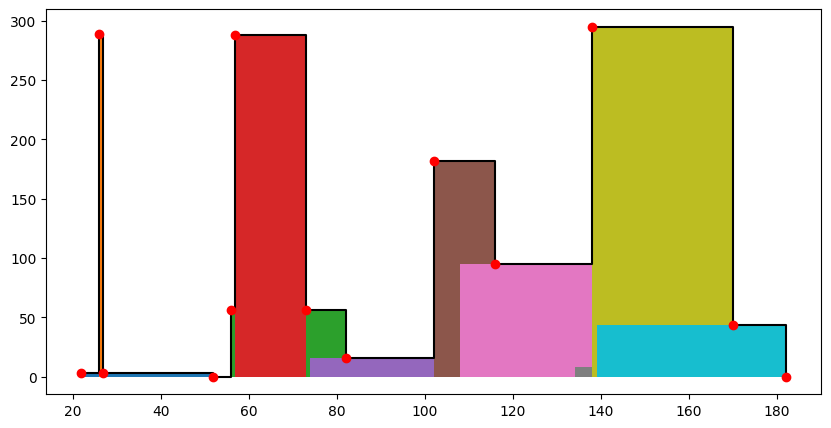

In [14]:
def skyline_divide_and_conquer(buildings):
    output = []
    skyline = []
    i, j =0,0

    skyline_height_a = 0
    skyline_height_b = 0

    if len(buildings) == 1:
        l, r, h = buildings[0]
        return [(l,h), (r,0)]
    
    half = len(buildings) // 2
    skyline_a = skyline_divide_and_conquer(buildings[:half]) 
    skyline_b = skyline_divide_and_conquer(buildings[half:])

    while i < len(skyline_a) and j < len(skyline_b):
        xa, ha = skyline_a[i]
        xb, hb = skyline_b[j]
        if xa <= xb:
            skyline_height_a = ha
            x = xa
            i += 1
        if xa >= xb:
            skyline_height_b = hb
            x = xb
            j += 1
        
        skyline.append((x, max(skyline_height_a, skyline_height_b)))
    
    skyline = skyline + skyline_b[j:]
    skyline = skyline + skyline_a[i:]
    last_h = 0
    for x,h in skyline:
        if h != last_h:
            output.append((x, h))
            last_h = h

    
    return output
verification_plot([(22, 52, 3), (26, 27, 289), (56, 82, 56), (57, 73, 288), (74, 106, 16), (102, 116, 182), (108, 153, 95), (134, 161, 8), (138, 170, 295), (139, 182, 44)], skyline_divide_and_conquer([(22, 52, 3), (26, 27, 289), (56, 82, 56), (57, 73, 288), (74, 106, 16), (102, 116, 182), (108, 153, 95), (134, 161, 8), (138, 170, 295), (139, 182, 44)]))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?
n <- Nombre de bâtiment
On peut utiliser le théorème maître pour déterminer la complexité asymptotique d'une fonction récursive.
On défini notre algorithme T(n) = l * T(n/b) + c*n^k
Notre «l» est le nombre d'appel à la fonction récursive. Avec cette version de diviser pour régner, on sépare le nombre de building en 2 à chaque itération. On fait donc deux appels.
Notre «b» est le quotien qui divise la taille de l'exemplaire pour nous donner la taille à utiliser à l'itération suivante. Comme on sépare les buildings en 2, b est égal à 2
Notre «cn^k» est l'ordre de complexité de la fonction de traitement du problème. Nous avons plusieurs traitement en O(1) dans une boucle en O(n). Pour que «cn^k» soit d'ordre O(n), k est égal à 1.

Selon le théorème maitre:

l < b^k -> 2 < 2^1 -> Faux
l = b^k -> 2 = 2^1 -> Vrai

Nous avons donc un algorithme d'ordre theta(n^k * log(n)) -> theta(n * log(n))


### Mesures (seuil 1)

In [15]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2143877, [10000,15000,20000,25000,30000,40000,50000,60000,70000,80000,90000, 100000, 110000, 120000, 130000, 140000, 150000])

In [16]:
measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer, dataset)

In [17]:
display_measures_table(measures_divide_naive_threshold)

Taille       Temps moyen (s)
10000        0.03911447525024414
15000        0.062491655349731445
20000        0.08387298583984375
25000        0.10757355690002442
30000        0.12725963592529296
40000        0.17283473014831544
50000        0.22964844703674317
60000        0.2785351276397705
70000        0.3382624626159668
80000        0.44295353889465333
90000        0.5621326446533204
100000       0.570964765548706
110000       0.5982749938964844
120000       0.5832901477813721
130000       0.6449962615966797
140000       0.6949560642242432
150000       0.7478593349456787


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

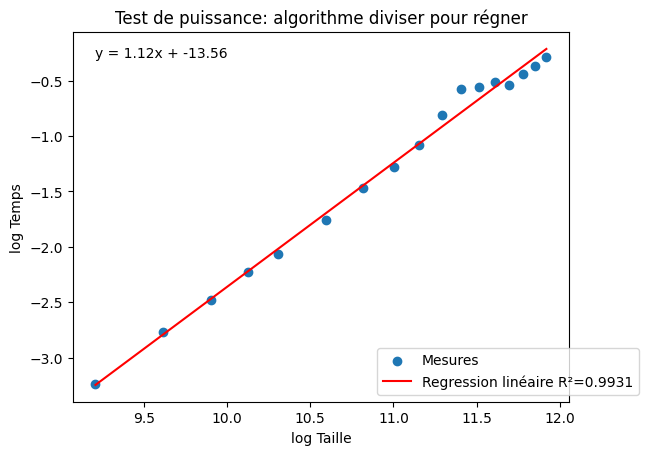

In [18]:
display_test_puissance(values_test_puissance(measures_divide_naive_threshold), "Test de puissance: algorithme diviser pour régner")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.
On observe que le graphique en échelle log-log du temps en fonction de la taille donne une droite, ce qui nous indique que l'algorithme suit un temps d'ordre polynomial.
La pente de la droite est de 1.12 et l'ordonnée à l'origine est -13.56. Nous faisons donc une hypothèse sur la fonction sous-jacente h(x) qui donne l'ordre de la complexité asymptotique temporelle de notre algorithme.
Hypothèse : m = 1.12 => h(x) = x^1.12

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

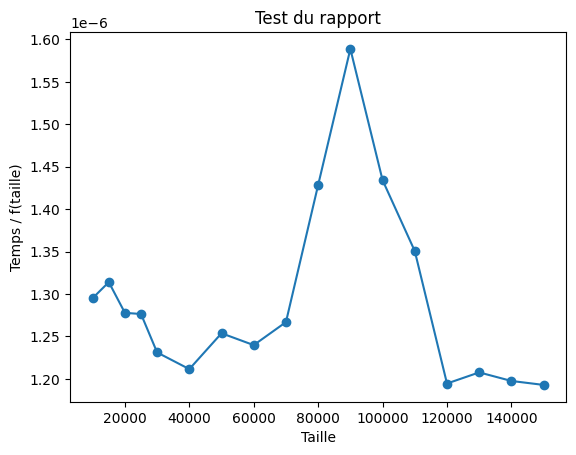

In [22]:
# TODO: définissez f judicieusement
def f(x):
    return x **1.12

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Le graphique qui représente le temps divisé par l'ordre de complexité en fonction de la taille de l'exemplaire semble donner un ensemble de points qui converge vers 1.2e-6.
On peut poser une hypothèse sur la constante multiplicative de l'algorithme naif.

Hypothèse : a = 1.2e-6

Cette valeur est comparable à l'ordonnée à l'origine du test de puissance dont la courbe est donné par: y = log(a) + m*log(x) => a = e^-13.56 = 1.29e-6

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

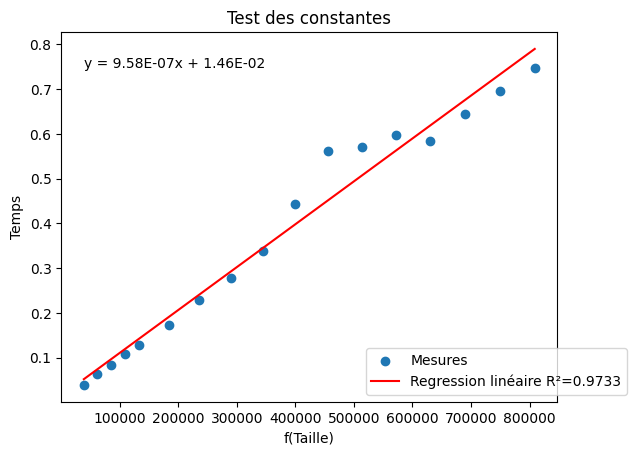

In [23]:
# TODO: définissez f judicieusement
def f(x):
    return 1.29 * x**1.12

display_test_constantes(values_test_constantes(measures_divide_naive_threshold, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

L'équation de la droite du test des constantes et donnée par : y = a*h(x) + b. En utilisant les valeurs trouvées précédemment, nous obtenons une ordonnée à l'origine positive qui est près de 0.
La constante b semble être 1.46e-02. Ceci voudrait dire que pour un exemplaire de taille 0, le temps d'exécution serait non-nul.

## Partie 3 : Algorithme diviser pour régner (seuil arbitraire) (5 pts)

### Selection du seuil

<u>**Question 1.a):**</u> Modifiez l'algorithme précédent pour y ajouter un seuil de récursivité (e.g. `threshold`). En dessous de ce seuil, vous utiliserez l'algorithme naïf écrit précédemment.

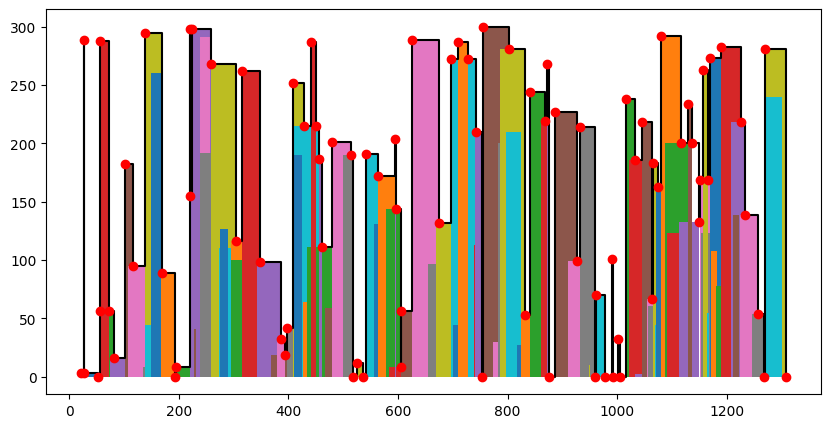

In [24]:
dataset = get_dataset(2143877, [100])
build = list(dataset.values())[0][0]
def skyline_divide_and_conquer_threshold(buildings, threshold=1):
    skyline = []
    output = []

    
    i, j =0,0
    skyline_height_a = 0
    skyline_height_b = 0
    if len(buildings) == 1:
        l, r, h = buildings[0]
        return [(l,h), (r,0)]
    
    if len(buildings) <= threshold:
        return skyline_bruteforce(buildings)
    
    half = len(buildings) // 2
    skyline_a = skyline_divide_and_conquer_threshold(buildings[:half], threshold ) 
    skyline_b = skyline_divide_and_conquer_threshold(buildings[half:], threshold)

    while i < len(skyline_a) and j < len(skyline_b):
        xa, ha = skyline_a[i]
        xb, hb = skyline_b[j]
        if xa <= xb:
            skyline_height_a = ha
            x = xa
            i += 1
        if xa >= xb:
            skyline_height_b = hb
            x = xb
            j += 1
        skyline.append((x, max(skyline_height_a, skyline_height_b)))
    skyline = skyline + skyline_b[j:]
    skyline = skyline + skyline_a[i:]
    last_h = 0
    for x,h in skyline:
        if h != last_h:
            output.append((x, h))
            last_h = h
    return output
    

verification_plot(build, skyline_divide_and_conquer_threshold(build,8))

<u>**Question 1.b):**</u> Effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux.

In [28]:
dataset = get_dataset(2143877, [10000,15000,20000,25000,30000,40000,50000,60000,70000,80000,90000, 100000, 110000, 120000, 130000, 140000, 150000])
build = list(dataset.values())[0][0]
measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer_threshold(sample, i),
        [build]) # TODO: sélectionnez un exemplaire 
        for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # TODO: testez une liste judicieuse de seuils
}


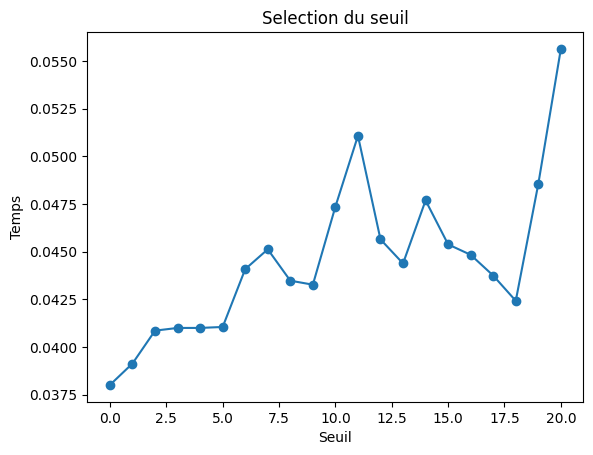

In [29]:
display_mesures_seuil(measures_threshold)

<u>**Question 1.c):**</u> Quel est le seuil de récursivité de le plus judicieux ? Sur quel critère l'avez vous sélectionné ? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances ?

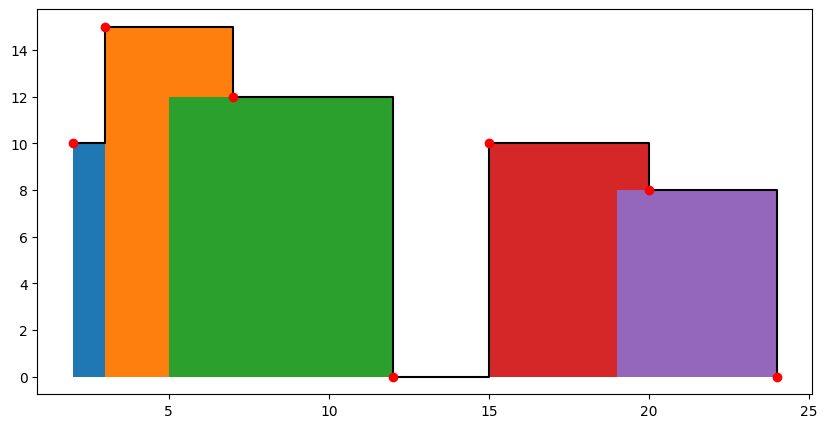

In [30]:
best_threshold = 0
verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings, best_threshold))

<u>**Question 1.d):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

### Mesures (seuil n)

In [31]:
measures_divide_best_threshold = measure_procedure(lambda sample : skyline_divide_and_conquer_threshold(sample, best_threshold), dataset)

In [32]:
display_measures_table(measures_divide_best_threshold)

Taille       Temps moyen (s)
10000        0.04119424819946289
15000        0.061731719970703126
20000        0.0844545841217041
25000        0.10941848754882813
30000        0.1308732509613037
40000        0.1792320728302002
50000        0.23019804954528808
60000        0.2803164482116699
70000        0.3332232475280762
80000        0.3909169673919678
90000        0.43497419357299805
100000       0.4825258255004883
110000       0.5348121643066406
120000       0.5950743198394776
130000       0.6506890773773193
140000       0.6998703479766846
150000       0.7571078777313233


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

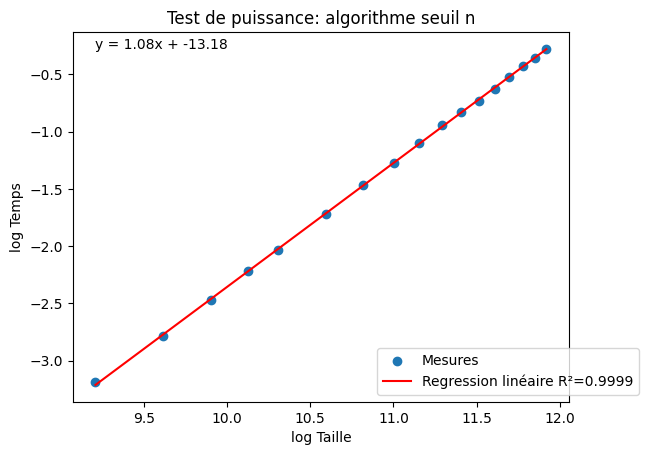

In [33]:
display_test_puissance(values_test_puissance(measures_divide_best_threshold), "Test de puissance: algorithme seuil n")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.
On observe que le graphique en échelle log-log du temps en fonction de la taille donne une droite, ce qui nous indique que l'algorithme suit un temps d'ordre polynomial.
La pente de la droite est de 1.08 et l'ordonnée à l'origine est -13.18. Nous faisons donc une hypothèse sur la fonction sous-jacente h(x) qui donne l'ordre de la complexité asymptotique temporelle de notre algorithme.
Hypothèse : m = 1.08 => h(x) = x^1.08

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

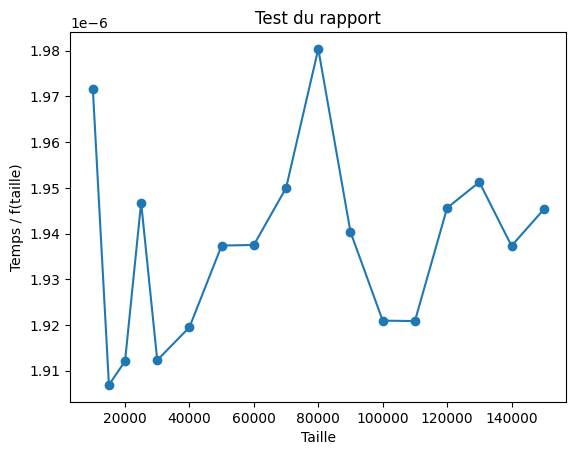

In [36]:
# TODO: définissez f judicieusement
def f(x):
    return x**1.08

display_test_rapport(values_test_rapport(measures_divide_best_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Le graphique qui représente le temps divisé par l'ordre de complexité en fonction de la taille de l'exemplaire semble donner un ensemble de points qui converge vers 1.94e-6.
On peut poser une hypothèse sur la constante multiplicative de l'algorithme naif.

Hypothèse : a = 1.94e-6

Cette valeur est comparable à l'ordonnée à l'origine du test de puissance dont la courbe est donné par: y = log(a) + m*log(x) => a = e^-13.13 = 1.88e-6

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

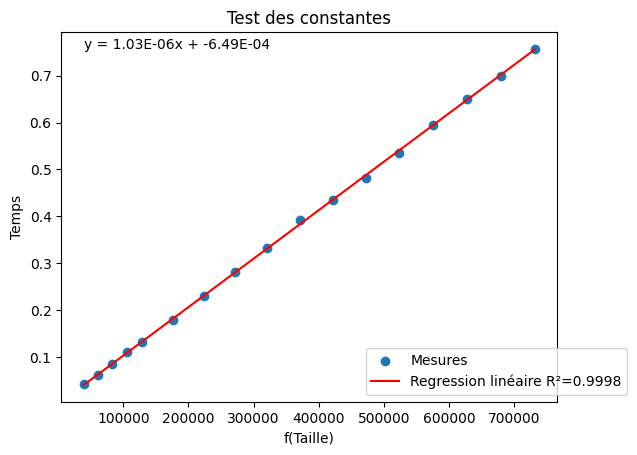

In [37]:
# TODO: définissez f judicieusement
def f(x):
    return 1.88 * x**1.08

display_test_constantes(values_test_constantes(measures_divide_best_threshold, f))


<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.
L'équation de la droite du test des constantes et donnée par : y = a*h(x) + b. En utilisant les valeurs trouvées précédemment, nous obtenons une ordonnée à l'origine positive qui est très près de 0.
La constante b semble être -6.49e-04. Ceci est impossible ce qui nous laisse croire que la vrai constante est 0.

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?
Le seuil représente le point ou l'algorithme diviser pour régner arrête les appels récursifs et utilise l'algorithme naif. Étrangement, dans notre cas nous avons obtenu un seuil de 0 ce qui veut dire que diviser pour régner est plus efficace que l'algorithme naif pour toute taille d'exemplaire. Nous soupçonnons une erreur dans le code implémentant le seuil.


# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces 3 algorithmes.

Selon notre analyse, on remarque que diviser-pour-régner possède la même complexité temporel avec ou sans seuil de récursion. Nos résultats pour le seuil de récursion sont surprenant, nous laissant croire que l'utilisation d'un seuil n'accélère pas en pratique la résolution du problème. C'est pourquoi nous pensons que notre code de la partie 3 est incorrect. Dans l'idéal, nous utiliserions l'algorithme naif pour tout les exemplaires plus petit ou égal au seuil alors que nous utiliserions diviser-pour-régner avec un seuil pour les exemplaires plus grand.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.